### **Agentic RAG – Short Summary**

This notebook builds an **Agentic RAG system** using **LangChain + LangGraph**.

### 🔹 **Key Flow**

- Load and split web documents  
- Create embeddings and store in **Chroma Vector DB**  
- Build a **retriever tool**  
- Define agent state for conversation tracking  
- Use LangGraph to manage reasoning and tool usage  

### **How It Works**
1. User asks a question  
2. Agent decides whether retrieval is needed  
3. Retrieves relevant documents (if required)  
4. Generates a grounded response  

### **Result**
A **tool-using AI agent** that performs intelligent retrieval, maintains state, and delivers context-aware, reliable answers.


In [ ]:
import warnings

warnings.filterwarnings("ignore")


### **Imports and Setup for LangChain & LangGraph-Based Conversational AI Workflow**

In [12]:
# Standard Python type hinting and type definitions
from typing import Annotated, Literal, Sequence, TypedDict  
# - Annotated: used to add metadata to types for validation or tooling  
# - Literal: restricts a variable to specific literal values  
# - Sequence: represents ordered collections (like lists or tuples)  
# - TypedDict: allows defining dictionary types with specific key-value types  


# Core message types used in LangChain conversations
from langchain_core.messages import BaseMessage, HumanMessage  
# - BaseMessage: generic message class  
# - HumanMessage: message specifically from a human user  

# Output parsing utilities from LangChain
from langchain_core.output_parsers import StrOutputParser  
# - StrOutputParser: parses output as a plain string  

# Prompt template utilities for building structured prompts
from langchain_core.prompts import PromptTemplate  

# Pydantic models for data validation and structured schema
from pydantic import BaseModel, Field  
# - BaseModel: base class for Pydantic models  
# - Field: used to provide extra metadata and validation for model fields  

# Functions for working with LangGraph message graphs
from langgraph.graph.message import add_messages  
# - add_messages: utility to add messages to a LangGraph state graph  

# Prebuilt condition-checking tools for LangGraph workflows
from langgraph.prebuilt import tools_condition  

# Document loaders for extracting web content
from langchain_community.document_loaders import WebBaseLoader  
# - WebBaseLoader: loads content from web pages  

# Vector store for semantic search and embeddings
from langchain_community.vectorstores import Chroma  
# - Chroma: a vector database for storing and querying embeddings  

# Utility to create retriever tools for information retrieval
from langchain_classic.tools.retriever import create_retriever_tool  

# Text splitter for breaking large texts into manageable chunks
from langchain_text_splitters import RecursiveCharacterTextSplitter  
# - RecursiveCharacterTextSplitter: splits text recursively on characters to fit chunk size  

# Core LangGraph graph classes and constants
from langgraph.graph import END, StateGraph, START  
# - START / END: special nodes marking the beginning and end of a graph  
# - StateGraph: represents a workflow graph of states and transitions  

# Prebuilt LangGraph node for connecting tools in a workflow
from langgraph.prebuilt import ToolNode  
# - ToolNode: a graph node that wraps a tool for execution within a workflow  


### **API Key Configuration and Environment Setup**

In [13]:
# Import the standard OS module to interact with environment variables
import os  

# Import the function to load environment variables from a .env file
from dotenv import load_dotenv  

# Load environment variables from a .env file into the program's environment
load_dotenv()  

# Retrieve API keys from environment variables (as set in the .env file)
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")   # Google API key
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")   # Tavily API key
GROQ_API_KEY = os.getenv("GROQ_API_KEY")       # Groq API key

# Set the retrieved API keys explicitly in the OS environment variables
# This ensures that other parts of the program or libraries can access them
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
os.environ["GROQ_API_KEY"] = GROQ_API_KEY


## **Import the HuggingFaceEmbeddings**

In [14]:
# Import the HuggingFaceEmbeddings class from LangChain
from langchain_huggingface import HuggingFaceEmbeddings  
# - HuggingFaceEmbeddings: allows you to load pre-trained Hugging Face models
#   for generating vector embeddings from text, which are used for semantic search, 
#   similarity comparisons, or machine learning tasks.

# Load a specific embedding model from Hugging Face
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")  
# - "all-MiniLM-L6-v2" is a lightweight, high-performance sentence embedding model.
# - The embeddings object can now be used to convert text into numerical vectors.


### **Initialize a Groq language model**

In [15]:
# Import the ChatGroq class from the LangChain Groq integration
from langchain_groq import ChatGroq  
# - ChatGroq: provides an interface to Groq AI models for chat and text generation.

# Initialize a Groq language model
llm=ChatGroq(model_name="openai/gpt-oss-120b")
# - "Gemma2-9b-It" specifies the particular Groq model to use (9 billion parameter


In [16]:
llm.invoke("hello how are you?")

AIMessage(content="Hello! I'm doing great, thank you for asking. How can I help you today?", additional_kwargs={'reasoning_content': 'The user says "hello how are you?" It\'s a friendly greeting. We should respond politely. No policy issues.'}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 76, 'total_tokens': 127, 'completion_time': 0.108502063, 'completion_tokens_details': {'reasoning_tokens': 24}, 'prompt_time': 0.003729294, 'prompt_tokens_details': None, 'queue_time': 0.004525038, 'total_time': 0.112231357}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_626f3fc5e0', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c418d-7c4d-7513-b649-4b8862b52cad-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 76, 'output_tokens': 51, 'total_tokens': 127, 'output_token_details': {'reasoning': 24}})

### **Web Document Loading and Text Splitting**


In [17]:
# List of URLs to load documents from
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
]

# Load documents from each URL using WebBaseLoader
# WebBaseLoader fetches the content of web pages and converts it into LangChain document objects
docs = [WebBaseLoader(url).load() for url in urls]

# Flatten the list of lists into a single list of documents
# Each URL might return multiple document objects, so this combines them all
docs_list = [item for sublist in docs for item in sublist]

# Initialize a text splitter that uses Tiktoken encoding for token-based splitting
# - chunk_size=100: each text chunk will have approximately 100 tokens
# - chunk_overlap=25: consecutive chunks will overlap by 25 tokens for context preservation
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, 
    chunk_overlap=25
)

# Split all loaded documents into smaller chunks
# This is useful for embedding generation, retrieval, and vector search
doc_splits = text_splitter.split_documents(docs_list)


#### **Create a vector store using Chroma**

In [18]:
# Create a vector store using Chroma from the split documents
vectorstore = Chroma.from_documents(
    documents=doc_splits,        # The list of text chunks to store
    collection_name="rag-chrome", # Name of the collection in the vector database
    embedding=embeddings          # Embedding model used to convert text into vectors
)

# Convert the vector store into a retriever
# The retriever can be used to perform semantic search and retrieve relevant documents
retriever = vectorstore.as_retriever()


### **Setup Retriever Tool for RAG Workflow**

In [19]:
# Create a specialized retriever tool using the previously defined retriever
retriever_tool = create_retriever_tool(
    retriever,  # The retriever object connected to the Chroma vector store
    "retrieve_blog_posts",  # Name of the tool
    # Description and instructions for the tool
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, "
    "and adversarial attacks on LLMs. You are a specialized assistant. "
    "Use the 'retriever_tool' **only** when the query explicitly relates to LangChain blog data. "
    "For all other queries, respond directly without using any tool. "
    "For simple queries like 'hi', 'hello', or 'how are you', provide a normal response.",
)

# Add the retriever tool to a list of tools
tools = [retriever_tool]  

# Wrap the retriever tool in a ToolNode for use in a LangGraph workflow
# ToolNode allows the tool to be executed as part of a larger graph-based workflow
retrieve = ToolNode([retriever_tool])


### **Define Agent State and Relevance Score Models**

In [20]:
# Define a TypedDict to represent the state of an agent in a conversation
class AgentState(TypedDict):
    # 'messages' holds a sequence of messages in the conversation
    # - Annotated is used to attach the 'add_messages' function as metadata
    #   which can automatically handle adding messages to the state graph
    messages: Annotated[Sequence[BaseMessage], add_messages]


# Define a Pydantic model to represent a grade or relevance score
class grade(BaseModel):
    # 'binary_score' is a string field representing relevance
    # - Expected values are "yes" or "no"
    # - Field description provides metadata for validation or documentation
    binary_score: str = Field(description="Relevance score 'yes' or 'no'")


### **AI Assistant and Document Processing Workflow**

In [21]:
from typing import Literal
from langchain_core.messages import HumanMessage

# ----------------------------
# AI Assistant Function
# ----------------------------
def ai_assistant(state: AgentState):
    """
    Main entry point for the AI assistant.
    Decides whether to use tools (like retriever) or answer directly.
    """
    print("---CALL AGENT---")
    messages = state['messages']
    
    if len(messages) > 1:
        # If there are previous messages, respond based on the latest user message
        last_message = messages[-1]
        question = last_message.content
        
        # Prompt for generating a general response
        prompt = PromptTemplate(
            template="""
            You are a helpful assistant. Answer the question based on the given input.
            Here is the question: {question}
            """,
            input_variables=["question"]
        )
        
        # Chain the prompt with the LLM
        chain = prompt | llm
        response = chain.invoke({"question": question})
        return {"messages": [response]}
    
    else:
        # If it's the first message, use LLM with the retriever tools
        llm_with_tool = llm.bind_tools(tools)
        response = llm_with_tool.invoke(messages)
        return {"messages": [response]}


# ----------------------------
# Document Grading Function
# ----------------------------
def grade_documents(state: AgentState) -> Literal["Output_Generator", "Query_Rewriter"]:
    """
    Grades documents as relevant or not relevant to the user's question.
    Returns the workflow node to go next: 'generator' or 'rewriter'.
    """
    # Wrap LLM with structured output based on the 'grade' model
    llm_with_structure_op = llm.with_structured_output(grade)
    
    # Prompt template for relevance grading
    prompt = PromptTemplate(
        template="""
        You are a grader deciding if a document is relevant to a user’s question.
        Here is the document: {context}
        Here is the user’s question: {question}
        If the document talks about or contains information related to the user’s question, mark it as relevant. 
        Give a 'yes' or 'no' answer to show if the document is relevant to the question.
        """,
        input_variables=["context", "question"]
    )
    
    chain = prompt | llm_with_structure_op
    
    # Extract messages from state
    messages = state["messages"]
    last_message = messages[-1]
    question = messages[0].content
    docs = last_message.content
    
    # Invoke the grading chain
    scored_result = chain.invoke({"question": question, "context": docs})
    score = scored_result.binary_score

    # Decide the next node in the workflow
    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generator"  # Go to document generation node
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        return "rewriter"   # Go to query rewriting node


# ----------------------------
# Document Generation Function
# ----------------------------
def generate(state: AgentState):
    """
    Generates a response based on the retrieved documents using a RAG-style chain.
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]
    docs = last_message.content
    
    # Pull prebuilt RAG prompt from LangChain Hub
    prompt = hub.pull("rlm/rag-prompt")
    rag_chain = prompt | llm
    
    # Generate response using context and question
    response = rag_chain.invoke({"context": docs, "question": question})
    print(f"this is my response: {response}")
    
    return {"messages": [response]}


# ----------------------------
# Query Rewriting Function
# ----------------------------
def rewrite(state: AgentState):
    """
    Rewrites the user's query to improve semantic clarity before retrieval.
    """
    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content
    
    # Create prompt to guide LLM in rewriting the question
    message = [
        HumanMessage(content=f"""
        Look at the input and try to reason about the underlying semantic intent or meaning. 
        Here is the initial question: {question} 
        Formulate an improved question: 
        """)
    ]
    
    # Invoke the LLM to rewrite the question
    response = llm.invoke(message)
    
    return {"messages": [response]}


### **LangGraph Workflow: AI Assistant with Document Retrieval and Generation**


In [22]:
# ----------------------------
# Create a LangGraph StateGraph
# ----------------------------
workflow = StateGraph(AgentState)
# - StateGraph manages the flow of nodes (functions) and messages between them
# - AgentState defines the structure of the state passed between nodes

# ----------------------------
# Add nodes to the workflow
# ----------------------------
workflow.add_node("My_Ai_Assistant", ai_assistant)
# - Main AI assistant node: decides whether to respond directly or call tools

workflow.add_node("Vector_Retriever", retrieve)
# - Node that handles document retrieval using the retriever tool

workflow.add_node("Output_Generator", generate)
# - Node that generates answers from retrieved documents (RAG-style)

workflow.add_node("Query_Rewriter", rewrite)
# - Node that rewrites user queries for better semantic understanding

# ----------------------------
# Define the starting point of the workflow
# ----------------------------
workflow.add_edge(START, "My_Ai_Assistant")
# - Connects the START node to the AI assistant node

# ----------------------------
# Add conditional edges from My_Ai_Assistant
# ----------------------------
workflow.add_conditional_edges(
    "My_Ai_Assistant",
    tools_condition,  # Function that checks if a tool should be used
    {
        "tools": "Vector_Retriever",  # If tools are needed, go to Vector_Retriever
        END: END                      # Otherwise, end the workflow
    }
)

# ----------------------------
# Add conditional edges from Vector_Retriever
# ----------------------------
workflow.add_conditional_edges(
    "Vector_Retriever",
    grade_documents,  # Function that grades document relevance
    {
        "generator": "Output_Generator",  # If relevant, go to output generation
        "rewriter": "Query_Rewriter"     # If not relevant, rewrite the query
    }
)

# ----------------------------
# Add regular edges
# ----------------------------
workflow.add_edge("Output_Generator", END)
# - After generating output, workflow ends

workflow.add_edge("Query_Rewriter", "My_Ai_Assistant")
# - After rewriting query, loop back to the AI assistant to reprocess

# ----------------------------
# Compile the workflow
# ----------------------------
app = workflow.compile()
# - Compiles the graph into an executable workflow
# - The `app` object can now be called with an initial state to run the entire process


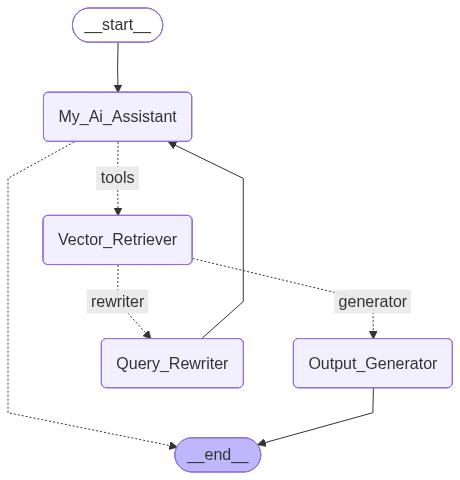

In [23]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [24]:
app.invoke({"messages":["What is a Autonomous Agent?"]})


---CALL AGENT---


{'messages': [HumanMessage(content='What is a Autonomous Agent?', additional_kwargs={}, response_metadata={}, id='3db4ec6b-9ec4-4466-9393-decfe8c1d179'),
  AIMessage(content='**Autonomous Agent – A concise definition**\n\nAn autonomous agent is a software system (or sometimes a robot) that **performs actions on its own** in order to achieve one or more goals, **without requiring continuous human intervention**. It perceives its environment, makes decisions, and executes actions based on those decisions. The key ingredients that make an agent “autonomous” are:\n\n| Component | What it means |\n|-----------|----------------|\n| **Perception / Sensing** | The agent gathers data from its surroundings (e.g., reading files, listening to a microphone, querying a web API, observing a game state). |\n| **Reasoning / Decision‑making** | Using that data, the agent runs a model, a set of rules, or a planning algorithm to decide what to do next. |\n| **Action / Actuation** | It carries out the chos

In [25]:
app.invoke({"messages":["what is a prompt engineering explain me in terms of agents and langchain?"]})

---CALL AGENT---


{'messages': [HumanMessage(content='what is a prompt engineering explain me in terms of agents and langchain?', additional_kwargs={}, response_metadata={}, id='44fa78bc-c01b-4017-801e-f108e1ad897c'),
  AIMessage(content='### Prompt Engineering\u202f—\u202fWhat It Is\n\n**Prompt engineering** is the craft of designing the text (the *prompt*) that you feed to a large language model (LLM) so that it reliably produces the output you want.  \nThink of a prompt as a **question, instruction, or context** that shapes the model’s “mental state” before it starts generating. Because LLMs are *stateless* and respond purely to the input they receive, the exact wording, structure, and examples you include can dramatically change the quality, style, and correctness of the answer.\n\nIn practice, prompt engineering involves:\n\n| Aspect | What It Means | Why It Matters |\n|--------|---------------|----------------|\n| **Clarity** | Use unambiguous language, explicit verbs, and clear constraints. | Red

In [27]:
app.invoke({"messages":["what is capital of Pakistan?"]})


---CALL AGENT---


{'messages': [HumanMessage(content='what is capital of Pakistan?', additional_kwargs={}, response_metadata={}, id='64a6a66e-17f3-4261-9fcc-ea755210c1fd'),
  AIMessage(content='The capital of Pakistan is **Islamabad**.', additional_kwargs={'reasoning_content': 'User asks: "what is capital of Pakistan?" This is a simple factual question, not about blog posts. Should answer directly.'}, response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 216, 'total_tokens': 262, 'completion_time': 0.097712312, 'completion_tokens_details': {'reasoning_tokens': 27}, 'prompt_time': 0.009818084, 'prompt_tokens_details': None, 'queue_time': 0.004955191, 'total_time': 0.107530396}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_e10890e4b9', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c418e-6442-7432-9342-b2ca20a28437-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 216, 'outpu